# Setup awal

In [1]:
import os
import numpy as np
import json
import pickle
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.optim as optim
from torch.optim import AdamW   
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split  
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import KFold  

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Dataset

In [3]:
dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

kelas = sorted(os.listdir(dataset_path))

jumlah_per_kelas = {}

for k in kelas:
    folder_path = os.path.join(dataset_path, k)
    file_list = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    jumlah_per_kelas[k] = len(file_list)

print("Jumlah gambar per kelas:")
for k, jml in jumlah_per_kelas.items():
    print(f"{k}: {jml}")

Jumlah gambar per kelas:
other_activities: 1184
safe_driving: 1679
talking_phone: 1513
texting_phone: 1561
turning: 1339


# Transformasi gambar

Kelas acak: other_activities
Gambar acak: img_21310.jpg
Path gambar: /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset/other_activities/img_21310.jpg


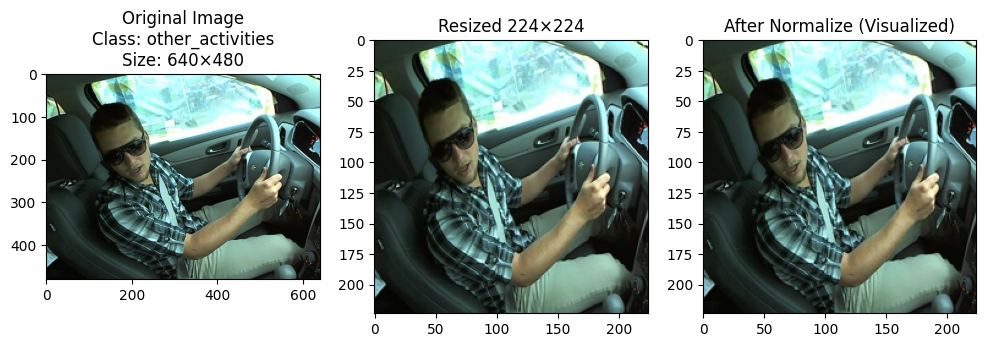

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================
# 1. SET PATH DATASET
# ============================

dataset_path = "/kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset"

# ambil semua folder kelas
kelas = sorted(os.listdir(dataset_path))

# pilih kelas random
kelas_random = random.choice(kelas)

# pilih gambar random dari kelas itu
gambar_list = os.listdir(os.path.join(dataset_path, kelas_random))
gambar_random = random.choice(gambar_list)

sample_image_path = os.path.join(dataset_path, kelas_random, gambar_random)

print("Kelas acak:", kelas_random)
print("Gambar acak:", gambar_random)
print("Path gambar:", sample_image_path)

# ============================
# 2. LOAD GAMBAR
# ============================

img_original = Image.open(sample_image_path).convert("RGB")
orig_w, orig_h = img_original.size

# resize
img_resized = img_original.resize((224, 224))

# convert ke numpy (0–1)
img_np = np.array(img_resized).astype("float32") / 255.0

# normalize imagenet
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_norm = (img_np - mean) / std

# unnormalize untuk visualisasi
img_unnorm = (img_norm * std) + mean
img_unnorm = np.clip(img_unnorm, 0, 1)

# ============================
# 3. PLOT GAMBAR
# ============================

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_original)
plt.title(f"Original Image\nClass: {kelas_random}\nSize: {orig_w}×{orig_h}")
plt.axis("on")

plt.subplot(1,3,2)
plt.imshow(img_resized)
plt.title("Resized 224×224")
plt.axis("on")

plt.subplot(1,3,3)
plt.imshow(img_unnorm)
plt.title("After Normalize (Visualized)")
plt.axis("on")

plt.show()

# Setup K-folds=5

In [5]:
json_path = '/kaggle/input/kfoldsta/Kfolds_TA.json'

with open(json_path, "r") as f:
    raw = json.load(f)

# Ekstrak meta dan override dataset_path/class_names bila ada
meta = raw.get("meta", {})
if isinstance(meta, dict):
    ds_root = meta.get("dataset_root")
    if ds_root:
        dataset_path = ds_root  # override global dataset path
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    if "n_splits" in meta:
        n_splits = int(meta["n_splits"])
    if "seed" in meta:
        seed = int(meta["seed"])

# Normalisasi folds: ambil semua key selain 'meta'
kfold_splits = {k: v for k, v in raw.items() if k != "meta"}

print("\nPembagian Data K-Fold (dari JSON)")
print(f"Dataset root   : {dataset_path}")
if "class_counts" in meta:
    total_imgs_meta = sum(meta["class_counts"].values())
    print(f"Total gambar   : {total_imgs_meta:,} (dari meta)")
    print("Kelas          : " + ", ".join(class_names))

first_fold_key = next(iter(sorted(kfold_splits.keys())))
first_fold = kfold_splits[first_fold_key]
train_count = len(first_fold.get("train", []))
val_count   = len(first_fold.get("val", []))
total_count = train_count + val_count 

print(f"Jumlah Fold    : {len(kfold_splits)}")
print(f"Train          : {train_count:,} gambar")
print(f"Val            : {val_count:,} gambar")
print(f"Total          : {total_count:,} gambar")


Pembagian Data K-Fold (dari JSON)
Dataset root   : /kaggle/input/datasetta/Multi-Class Driver Behavior Image Dataset
Jumlah Fold    : 5
Train          : 5,820 gambar
Val            : 1,456 gambar
Total          : 7,276 gambar


# Dataset loader untuk memuat gambar dan label

In [6]:
class DriverBehaviorDataset(Dataset):
    def __init__(self, root_dir, file_list, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        rel_path = self.file_list[idx]
        # Normalisasi path JSON (posix) ke path OS lokal (Windows)
        local_rel = rel_path.replace("/", os.sep)
        img_path = os.path.normpath(os.path.join(self.root_dir, local_rel))

        image = Image.open(img_path).convert('RGB')

        # Ambil label dari segmen folder pertama di path JSON
        class_name = rel_path.split("/", 1)[0]
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Loader dataset berbasis JSON

In [7]:
def load_dataloaders_from_split_json(json_path, dataset_path, fold_name,
                                     batch_size=32, img_size=(224, 224)):
    
    with open(json_path, "r") as f:
        raw = json.load(f)

    meta = raw.get("meta", {})
    ds_root = meta.get("dataset_root") or dataset_path

    # Ambil nama kelas
    if "class_counts" in meta and isinstance(meta["class_counts"], dict):
        class_names = sorted(meta["class_counts"].keys())
    else:
        class_names = sorted(
            [d for d in os.listdir(ds_root)
             if os.path.isdir(os.path.join(ds_root, d))]
        )

    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    # Transform image
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cek fold
    folds_data = {k: v for k, v in raw.items() if k != "meta"}
    if fold_name not in folds_data:
        raise KeyError(f"Fold '{fold_name}' tidak ditemukan di JSON.")

    fold = folds_data[fold_name]
    train_files = fold.get("train", [])
    val_files   = fold.get("val", [])

    # Dataset
    train_dataset = DriverBehaviorDataset(ds_root, train_files, class_to_idx, transform)
    val_dataset   = DriverBehaviorDataset(ds_root, val_files,   class_to_idx, transform)

    # DataLoader
    num_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)

    return train_loader, val_loader, class_to_idx, class_names, ds_root

# Model

In [8]:
num_classes = len(os.listdir(dataset_path))

def vgg11_model(num_classes):
    model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    return model

model = vgg11_model(num_classes)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 229MB/s] 


# Training dan evaluasi model vgg11 

Training Fold 1
Epoch [1/15] Train Loss: 0.5791 Acc: 0.7617 | Val Loss: 0.2127 Acc: 0.9238
Epoch [2/15] Train Loss: 0.1611 Acc: 0.9409 | Val Loss: 0.1765 Acc: 0.9382
Epoch [3/15] Train Loss: 0.0947 Acc: 0.9655 | Val Loss: 0.1657 Acc: 0.9396
Epoch [4/15] Train Loss: 0.0479 Acc: 0.9847 | Val Loss: 0.1633 Acc: 0.9519
Epoch [5/15] Train Loss: 0.0447 Acc: 0.9856 | Val Loss: 0.2343 Acc: 0.9423
Epoch [6/15] Train Loss: 0.0412 Acc: 0.9880 | Val Loss: 0.1676 Acc: 0.9540
Epoch [7/15] Train Loss: 0.0219 Acc: 0.9933 | Val Loss: 0.1315 Acc: 0.9650
Epoch [8/15] Train Loss: 0.0328 Acc: 0.9911 | Val Loss: 0.3082 Acc: 0.9238
Epoch [9/15] Train Loss: 0.0423 Acc: 0.9880 | Val Loss: 0.1527 Acc: 0.9567
Epoch [10/15] Train Loss: 0.0135 Acc: 0.9957 | Val Loss: 0.2241 Acc: 0.9602
Epoch [11/15] Train Loss: 0.0092 Acc: 0.9976 | Val Loss: 0.1501 Acc: 0.9609
Epoch [12/15] Train Loss: 0.0163 Acc: 0.9948 | Val Loss: 0.3014 Acc: 0.9512
Epoch [13/15] Train Loss: 0.0289 Acc: 0.9921 | Val Loss: 0.2080 Acc: 0.9402
Epoch

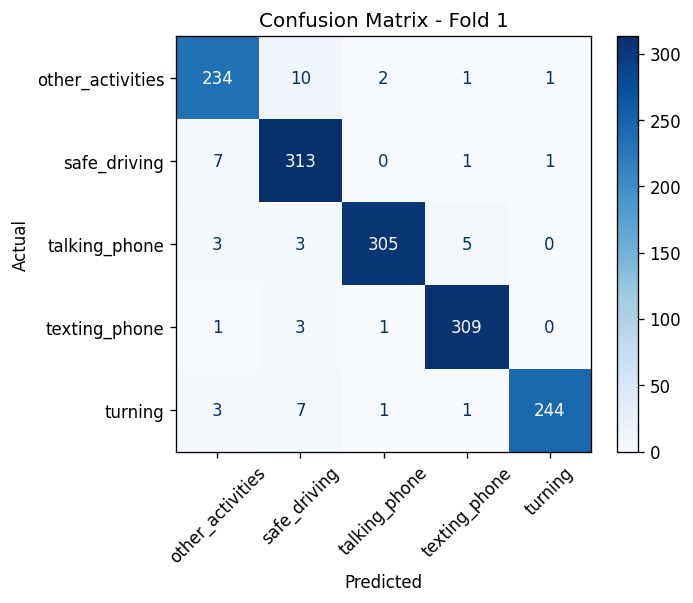

Training Fold 2
Epoch [1/15] Train Loss: 0.5747 Acc: 0.7667 | Val Loss: 0.2159 Acc: 0.9182
Epoch [2/15] Train Loss: 0.1446 Acc: 0.9462 | Val Loss: 0.1763 Acc: 0.9381
Epoch [3/15] Train Loss: 0.0926 Acc: 0.9662 | Val Loss: 0.1305 Acc: 0.9546
Epoch [4/15] Train Loss: 0.0672 Acc: 0.9773 | Val Loss: 0.1590 Acc: 0.9478
Epoch [5/15] Train Loss: 0.0221 Acc: 0.9918 | Val Loss: 0.1390 Acc: 0.9546
Epoch [6/15] Train Loss: 0.0272 Acc: 0.9909 | Val Loss: 0.1674 Acc: 0.9512
Epoch [7/15] Train Loss: 0.0389 Acc: 0.9878 | Val Loss: 0.2289 Acc: 0.9450
Epoch [8/15] Train Loss: 0.0393 Acc: 0.9878 | Val Loss: 0.2612 Acc: 0.9505
Epoch [9/15] Train Loss: 0.0289 Acc: 0.9906 | Val Loss: 0.1697 Acc: 0.9643
Epoch [10/15] Train Loss: 0.0052 Acc: 0.9985 | Val Loss: 0.1950 Acc: 0.9649
Epoch [11/15] Train Loss: 0.0030 Acc: 0.9993 | Val Loss: 0.1944 Acc: 0.9622
Epoch [12/15] Train Loss: 0.0141 Acc: 0.9967 | Val Loss: 0.1617 Acc: 0.9540
Epoch [13/15] Train Loss: 0.0228 Acc: 0.9947 | Val Loss: 0.2015 Acc: 0.9423
Epoch

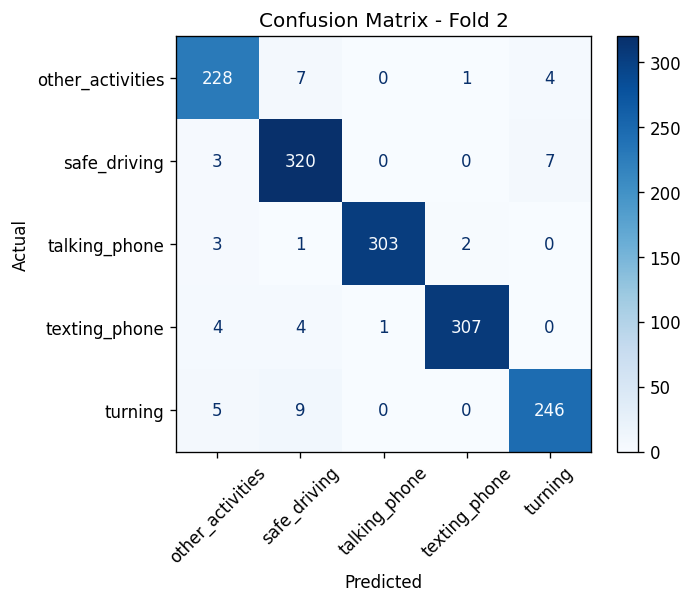

Training Fold 3
Epoch [1/15] Train Loss: 0.6650 Acc: 0.7253 | Val Loss: 0.1995 Acc: 0.9299
Epoch [2/15] Train Loss: 0.1601 Acc: 0.9400 | Val Loss: 0.2139 Acc: 0.9175
Epoch [3/15] Train Loss: 0.0904 Acc: 0.9656 | Val Loss: 0.1582 Acc: 0.9443
Epoch [4/15] Train Loss: 0.0614 Acc: 0.9765 | Val Loss: 0.1300 Acc: 0.9478
Epoch [5/15] Train Loss: 0.0518 Acc: 0.9821 | Val Loss: 0.1253 Acc: 0.9588
Epoch [6/15] Train Loss: 0.0353 Acc: 0.9883 | Val Loss: 0.1439 Acc: 0.9498
Epoch [7/15] Train Loss: 0.0407 Acc: 0.9871 | Val Loss: 0.1894 Acc: 0.9436
Epoch [8/15] Train Loss: 0.0192 Acc: 0.9942 | Val Loss: 0.1919 Acc: 0.9622
Epoch [9/15] Train Loss: 0.0095 Acc: 0.9960 | Val Loss: 0.1509 Acc: 0.9581
Epoch [10/15] Train Loss: 0.0091 Acc: 0.9979 | Val Loss: 0.1826 Acc: 0.9636
Epoch [11/15] Train Loss: 0.0539 Acc: 0.9839 | Val Loss: 0.1829 Acc: 0.9540
Epoch [12/15] Train Loss: 0.0221 Acc: 0.9928 | Val Loss: 0.1535 Acc: 0.9553
Epoch [13/15] Train Loss: 0.0191 Acc: 0.9950 | Val Loss: 0.2115 Acc: 0.9402
Epoch

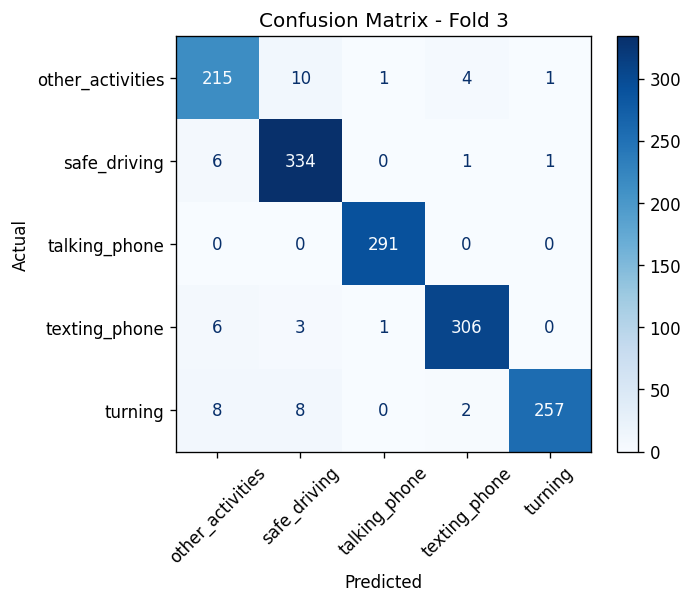

Training Fold 4
Epoch [1/15] Train Loss: 0.5497 Acc: 0.7806 | Val Loss: 0.2781 Acc: 0.8983
Epoch [2/15] Train Loss: 0.1449 Acc: 0.9443 | Val Loss: 0.1624 Acc: 0.9395
Epoch [3/15] Train Loss: 0.0890 Acc: 0.9677 | Val Loss: 0.1501 Acc: 0.9450
Epoch [4/15] Train Loss: 0.0611 Acc: 0.9784 | Val Loss: 0.1630 Acc: 0.9361
Epoch [5/15] Train Loss: 0.0543 Acc: 0.9837 | Val Loss: 0.1617 Acc: 0.9471
Epoch [6/15] Train Loss: 0.0399 Acc: 0.9881 | Val Loss: 0.2113 Acc: 0.9450
Epoch [7/15] Train Loss: 0.0240 Acc: 0.9921 | Val Loss: 0.2453 Acc: 0.9402
Epoch [8/15] Train Loss: 0.0285 Acc: 0.9916 | Val Loss: 0.1581 Acc: 0.9485
Epoch [9/15] Train Loss: 0.0104 Acc: 0.9967 | Val Loss: 0.1737 Acc: 0.9574
Epoch [10/15] Train Loss: 0.0072 Acc: 0.9974 | Val Loss: 0.1791 Acc: 0.9567
Epoch [11/15] Train Loss: 0.0449 Acc: 0.9869 | Val Loss: 0.2069 Acc: 0.9409
Epoch [12/15] Train Loss: 0.0323 Acc: 0.9899 | Val Loss: 0.1921 Acc: 0.9505
Epoch [13/15] Train Loss: 0.0246 Acc: 0.9930 | Val Loss: 0.1803 Acc: 0.9498
Epoch

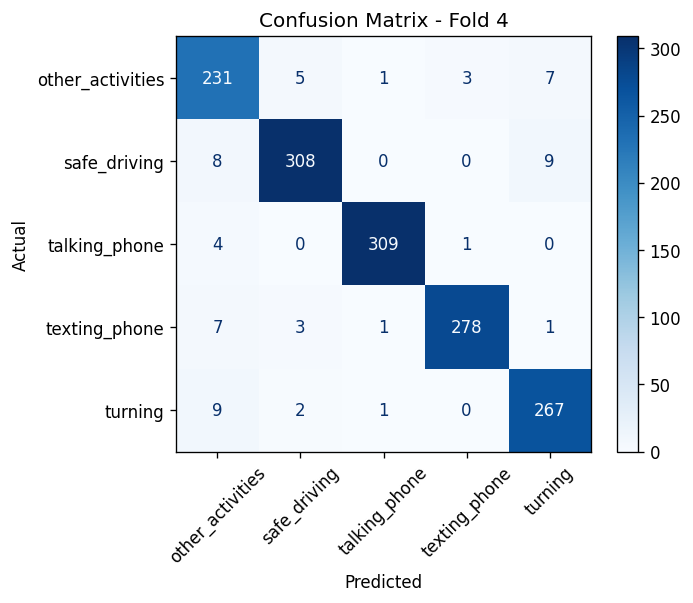

Training Fold 5
Epoch [1/15] Train Loss: 0.5566 Acc: 0.7784 | Val Loss: 0.1522 Acc: 0.9478
Epoch [2/15] Train Loss: 0.1583 Acc: 0.9395 | Val Loss: 0.1003 Acc: 0.9622
Epoch [3/15] Train Loss: 0.0909 Acc: 0.9682 | Val Loss: 0.1203 Acc: 0.9601
Epoch [4/15] Train Loss: 0.0711 Acc: 0.9778 | Val Loss: 0.1143 Acc: 0.9629
Epoch [5/15] Train Loss: 0.0432 Acc: 0.9847 | Val Loss: 0.1380 Acc: 0.9677
Epoch [6/15] Train Loss: 0.0401 Acc: 0.9868 | Val Loss: 0.2013 Acc: 0.9581
Epoch [7/15] Train Loss: 0.0283 Acc: 0.9906 | Val Loss: 0.1249 Acc: 0.9684
Epoch [8/15] Train Loss: 0.0201 Acc: 0.9930 | Val Loss: 0.1309 Acc: 0.9704
Epoch [9/15] Train Loss: 0.0153 Acc: 0.9959 | Val Loss: 0.1504 Acc: 0.9711
Epoch [10/15] Train Loss: 0.0070 Acc: 0.9981 | Val Loss: 0.1564 Acc: 0.9691
Epoch [11/15] Train Loss: 0.0031 Acc: 0.9991 | Val Loss: 0.1464 Acc: 0.9698
Epoch [12/15] Train Loss: 0.0024 Acc: 0.9995 | Val Loss: 0.1574 Acc: 0.9698
Epoch [13/15] Train Loss: 0.0002 Acc: 1.0000 | Val Loss: 0.1669 Acc: 0.9698
Epoch

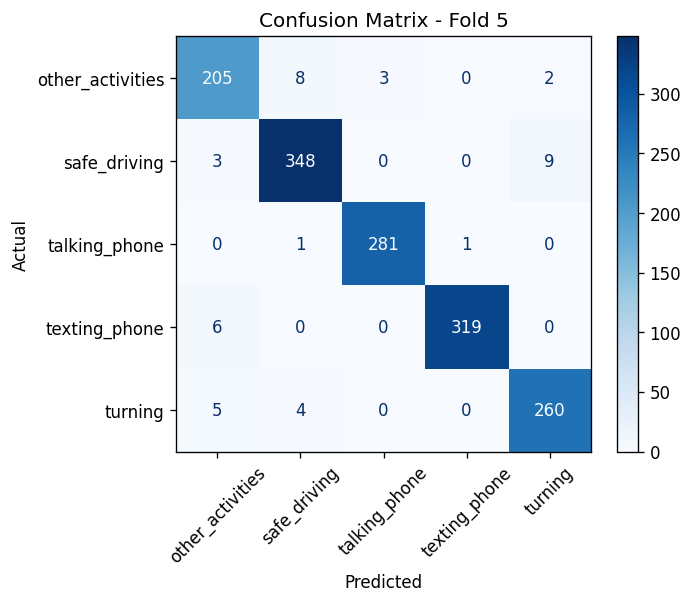

In [9]:
# Hyperparameter
num_epochs = 15
learning_rate = 0.0001

# Dictionary untuk menyimpan hasil semua fold
all_fold_results = {}

# Fungsi training per fold dengan tracking yang lebih detail
def train_fold(fold_name, train_loader, val_loader, num_classes):
    print(f"Training {fold_name.replace('_', ' ').title()}")

    model = vgg11_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_epoch = 0
    best_model_path = f'{fold_name}_best_model.pth'

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, disable=True, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, disable=True, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Track best validation accuracy dan simpan model terbaik
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), best_model_path)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Evaluasi pada validation set menggunakan model terbaik
    best_model = vgg11_model(num_classes).to(device)
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            preds = outputs.argmax(1).detach().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    # Gunakan nama kelas jika tersedia
    if 'class_names' in globals() and len(class_names) == num_classes:
        target_names = [str(c) for c in class_names]
    else:
        target_names = [str(i) for i in range(num_classes)]
    cls_report = classification_report(
        all_labels, all_preds,
        labels=list(range(num_classes)),
        target_names=target_names,
        digits=4, zero_division=0
    )
    print("Evaluasi Model:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(cls_report)

    # Plot confusion matrix
    labels_display = class_names if 'class_names' in globals() else list(range(num_classes))
    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
    disp.plot(include_values=True, cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f'Confusion Matrix - {fold_name.replace("_", " ").title()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.tick_params(axis='x', labelrotation=45)
    plt.tight_layout()
    plt.show()

    # Simpan hasil fold
    fold_results = {
        'fold_name': fold_name,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'eval': {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'confusion_matrix': cm,
            'classification_report': cls_report,
        },
        'best_model_path': best_model_path
    }
    
    # Simpan ke dictionary global
    all_fold_results[fold_name] = fold_results
    
    # Simpan hasil fold ke file
    with open(f'{fold_name}_results.pkl', 'wb') as f:
        pickle.dump(fold_results, f)
    
    return fold_results

def train_all_folds(fold_loaders, num_classes):
    results = {}
    for fold_name, loaders in fold_loaders.items():
        if isinstance(loaders, dict):
            train_loader = loaders.get('train') or loaders.get('train_loader')
            val_loader = loaders.get('val') or loaders.get('val_loader')
        else:
            train_loader, val_loader = loaders
        results[fold_name] = train_fold(fold_name, train_loader, val_loader, num_classes)
    with open('all_folds_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    return results

fold_names = sorted(kfold_splits.keys(), key=lambda n: int(n.split("_")[-1]) if n.split("_")[-1].isdigit() else n)

fold_loaders = {}
class_names = None  
for fold_name in fold_names:
    tr_loader, va_loader, class_to_idx, class_names_local, ds_root = load_dataloaders_from_split_json(
        json_path=json_path,
        dataset_path=dataset_path,
        fold_name=fold_name,
        batch_size=32,
        img_size=(224, 224),
    )
    fold_loaders[fold_name] = {'train': tr_loader, 'val': va_loader}
    if class_names is None:
        class_names = class_names_local
        dataset_path = ds_root  
num_classes = len(class_names)
all_fold_results = train_all_folds(fold_loaders, num_classes)

# Evaluasi rata-rata kfold

In [10]:
print("\n==================== HASIL K-FOLD CROSS VALIDATION ====================\n")

acc_list = []
prec_list = []
rec_list = []
f1_list = []

for fold_name, result in sorted(all_fold_results.items(), key=lambda x: int(x[0].split("_")[-1])):
    acc  = result['eval']['accuracy']
    prec = result['eval']['precision']
    rec  = result['eval']['recall']
    f1   = result['eval']['f1']

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)

    print(f"{fold_name}:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}")
    print(f"  Recall    : {rec:.4f}")
    print(f"  F1-Score  : {f1:.4f}")
    print("-" * 60)

# Hitung rata-rata seluruh fold
mean_acc  = np.mean(acc_list)
mean_prec = np.mean(prec_list)
mean_rec  = np.mean(rec_list)
mean_f1   = np.mean(f1_list)

print("\n====================== RATA-RATA 5 FOLD ======================\n")
print(f"Avg Accuracy  : {mean_acc:.4f}")
print(f"Avg Precision : {mean_prec:.4f}")
print(f"Avg Recall    : {mean_rec:.4f}")
print(f"Avg F1-Score  : {mean_f1:.4f}")


==================== HASIL K-FOLD CROSS VALIDATION ====================

fold_1:
  Accuracy  : 0.9650
  Precision : 0.9658
  Recall    : 0.9636
  F1-Score  : 0.9645
------------------------------------------------------------
fold_2:
  Accuracy  : 0.9649
  Precision : 0.9642
  Recall    : 0.9636
  F1-Score  : 0.9638
------------------------------------------------------------
fold_3:
  Accuracy  : 0.9643
  Precision : 0.9638
  Recall    : 0.9620
  F1-Score  : 0.9626
------------------------------------------------------------
fold_4:
  Accuracy  : 0.9574
  Precision : 0.9554
  Recall    : 0.9565
  F1-Score  : 0.9558
------------------------------------------------------------
fold_5:
  Accuracy  : 0.9711
  Precision : 0.9692
  Recall    : 0.9696
  F1-Score  : 0.9694
------------------------------------------------------------

====================== RATA-RATA 5 FOLD ======================

Avg Accuracy  : 0.9645
Avg Precision : 0.9636
Avg Recall    : 0.9631
Avg F1-Score  : 0.9632


# Evaluasi menggunakan data test

In [12]:
# FUNGSI VALIDASI 
def validate(model, dataloader, criterion, device="cuda"):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    if len(dataloader.dataset) == 0:
        print("⚠ Dataset validation kosong!")
        return 0, 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            try:
                images, labels = batch
            except Exception as e:
                print(f"❌ Error membaca batch {batch_idx}: {e}")
                continue

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    if total_samples == 0:
        return 0, 0

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc



# VALIDATION LOOP                          
criterion = nn.CrossEntropyLoss()
val_results = {}

for fold_name in fold_loaders.keys():

    print(f"\n=== Evaluasi Validation Set: {fold_name} ===")

    # Load model terbaik per fold 
    model_path = f"/kaggle/working/{fold_name}_best_model.pth"

    model = models.vgg11(weights='DEFAULT')
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # Load checkpoint
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Ambil val loader
    val_loader = DataLoader(
        fold_loaders[fold_name]["val"].dataset,
        batch_size=fold_loaders[fold_name]["val"].batch_size,
        shuffle=False,
        num_workers=2,            
        pin_memory=False
    )

    # Hitung loss & akurasi
    val_loss, val_acc = validate(model, val_loader, criterion, device=device)

    val_results[fold_name] = {
        "loss": val_loss,
        "acc": val_acc
    }

    print(f"Validation Loss : {val_loss:.4f}")
    print(f"Validation Acc  : {val_acc * 100:.2f}%")


mean_acc  = np.mean([v["acc"]  for v in val_results.values()])
mean_loss = np.mean([v["loss"] for v in val_results.values()])

print("\n=== RATA-RATA VALIDATION SET ===")
print(f"Avg Loss : {mean_loss:.4f}")
print(f"Avg Acc  : {mean_acc * 100:.2f}%")


=== Evaluasi Validation Set: fold_1 ===
Validation Loss : 0.1315
Validation Acc  : 96.50%

=== Evaluasi Validation Set: fold_2 ===
Validation Loss : 0.1950
Validation Acc  : 96.49%

=== Evaluasi Validation Set: fold_3 ===
Validation Loss : 0.1711
Validation Acc  : 96.43%

=== Evaluasi Validation Set: fold_4 ===
Validation Loss : 0.1737
Validation Acc  : 95.74%

=== Evaluasi Validation Set: fold_5 ===
Validation Loss : 0.1504
Validation Acc  : 97.11%

=== RATA-RATA VALIDATION SET ===
Avg Loss : 0.1644
Avg Acc  : 96.45%


# Visualisasi akurasi tiap fold

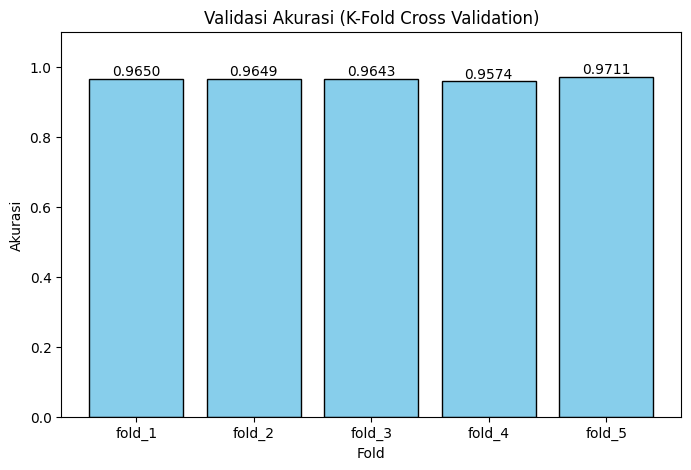

In [14]:
with open("/kaggle/working/all_folds_results.pkl", "rb") as f:
    all_fold_results = pickle.load(f)

fold_names = list(all_fold_results.keys())
accuracies = [v['eval']['accuracy'] for v in all_fold_results.values()]

# Pastikan data tidak kosong
if len(accuracies) == 0:
    print("⚠️ Tidak ada data akurasi di file all_fold_results.pkl. Pastikan training sudah selesai dengan benar.")
else:
    # === 3️⃣ Visualisasi dengan diagram batang ===
    plt.figure(figsize=(8,5))
    bars = plt.bar(fold_names, accuracies, color='skyblue', edgecolor='black')
    plt.title("Validasi Akurasi (K-Fold Cross Validation)")
    plt.xlabel("Fold")
    plt.ylabel("Akurasi")
    plt.ylim(0, 1.1)

    # Tambahkan nilai akurasi di atas setiap batang
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=10)

    plt.show()

# Visualisasi kurva per epoch

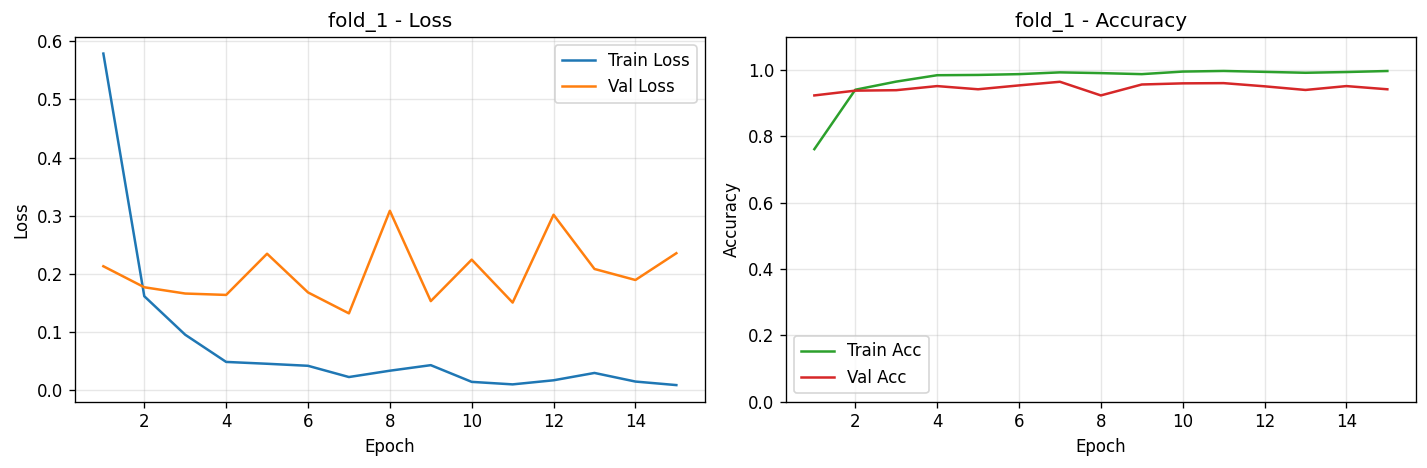

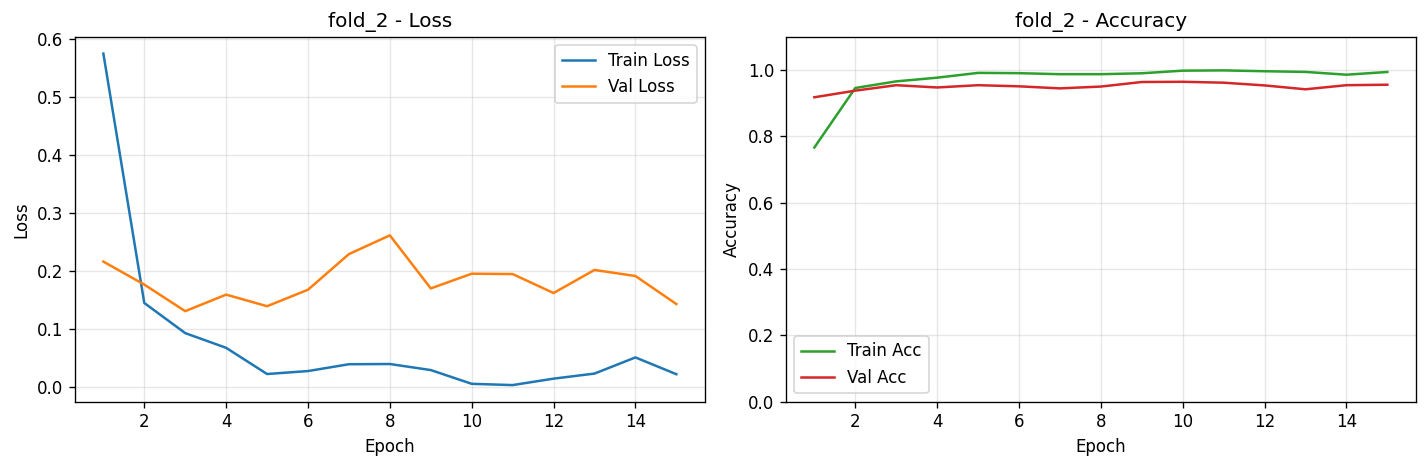

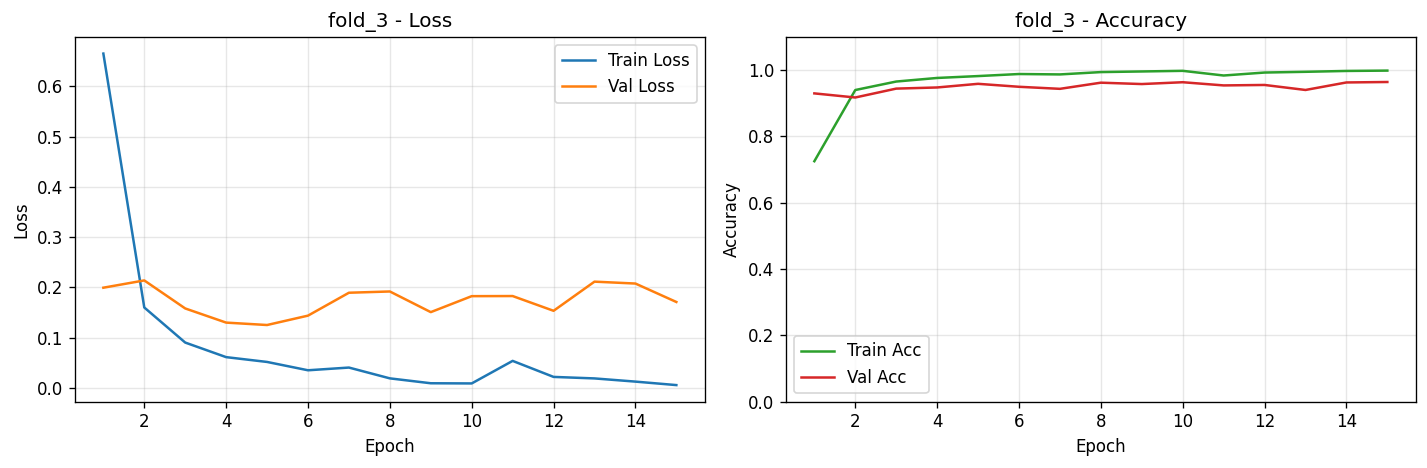

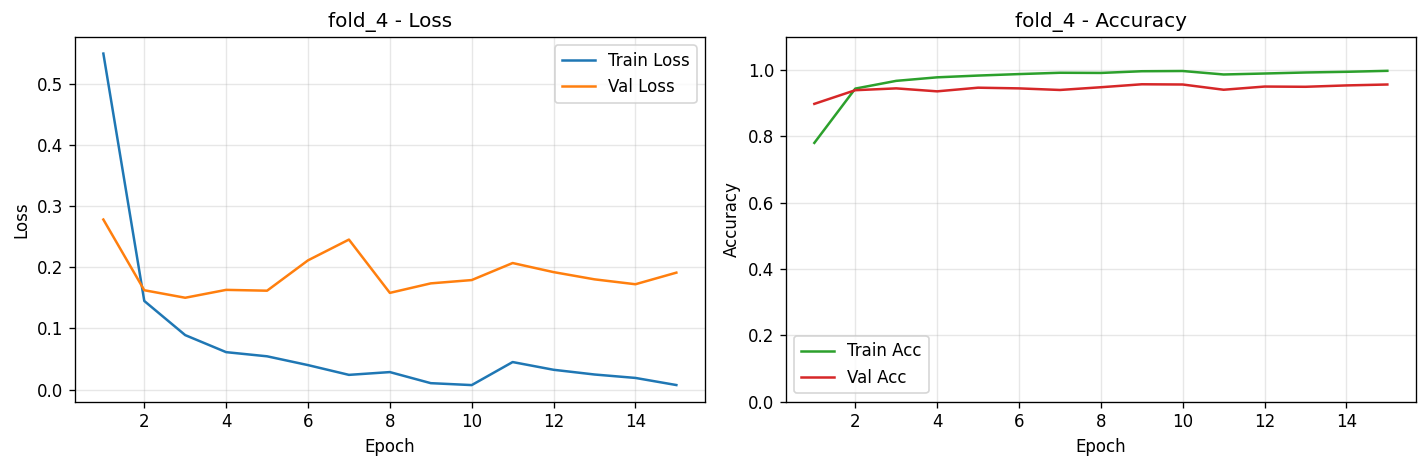

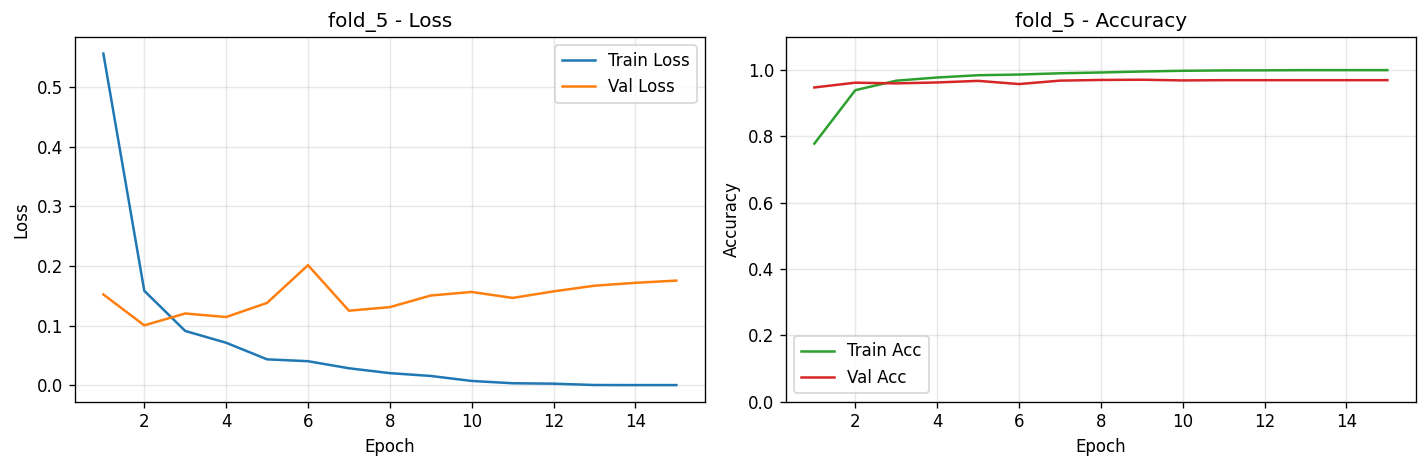

In [15]:
# Visualisasi hasil training setiap fold

def _collect_fold_results():
    results = {}
    # 1) Ambil dari variabel global jika sudah ada
    if 'all_fold_results' in globals() and isinstance(all_fold_results, dict) and len(all_fold_results) > 0:
        results.update(all_fold_results)
    return results

def _fold_sort_key(name):
    # Coba ekstrak angka urutan dari nama fold (misal "fold_3" -> 3)
    parts = name.replace('-', '_').split('_')
    for p in parts:
        if p.isdigit():
            return int(p)
    return 0

fold_results = _collect_fold_results()
if not fold_results:
    print("Tidak ditemukan hasil training fold. Jalankan training terlebih dahulu.")
else:
    # Urutkan fold agar rapi
    fold_names_sorted = sorted(fold_results.keys(), key=_fold_sort_key)

    # Plot per fold: kurva Loss dan Accuracy
    for fold_name in fold_names_sorted:
        fr = fold_results[fold_name]
        train_losses = fr.get('train_losses', [])
        val_losses = fr.get('val_losses', [])
        train_accs = fr.get('train_accs', [])
        val_accs = fr.get('val_accs', [])

        epochs = range(1, len(train_losses) + 1) if train_losses else range(1, len(val_losses) + 1)

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)
        # Loss
        axes[0].plot(epochs, train_losses, label='Train Loss', color='tab:blue')
        axes[0].plot(epochs, val_losses, label='Val Loss', color='tab:orange')
        axes[0].set_title(f'{fold_name} - Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # Accuracy
        axes[1].plot(epochs, train_accs, label='Train Acc', color='tab:green')
        axes[1].plot(epochs, val_accs, label='Val Acc', color='tab:red')
        axes[1].set_title(f'{fold_name} - Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim(0, 1.1)
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()

        plt.tight_layout()
        plt.show()